# Tracy Widom test
Implementation according to Patterson 2006, PLoS Genetics.
Variable names are in accordance as much as possible.

In [34]:
import numpy as np
from TracyWidom import TracyWidom
import scipy
import pandas as pd
import matplotlib.pyplot as plt


### Moment estimator
Equation (10) in Patterson et al.

$$n' = \frac{(m+1)(\sum_{i}\lambda_i)^2}
{(m-1)\sum_{i}\lambda_i^2 - (\sum_{i}\lambda_i)^2}$$

In [35]:
def nprime(m, lambdas):
    import pdb
    t1 = (lambdas.sum())**2
    numer = (m+1) * t1
    denom = (m-1) * (lambdas **2).sum() - t1
    if numer/denom < 0: pdb.set_trace()
    return numer/denom

In [31]:
def twstats(lambdas):
    import pdb
    tw = TracyWidom(beta=1)
    stats = []
    for m in range(len(lambdas), 1, -1):
        m1 = m - 1
        n1 = nprime(m, lambdas)
        if n1 < 1: pdb.set_trace()
        mumn = ((np.sqrt(n1-1) + np.sqrt(m))**2)/n1 ## Eq (5)
        sigmn = (np.sqrt(n1-1) + np.sqrt(m))/n1 * (1/np.sqrt(n1-1) + 1/np.sqrt(m))**(1/3.) # Eq (6)
        l = m1*lambdas[0]/lambdas.sum() ## extend to all lambdas
        x = (l - mumn)/sigmn  # Eq (7)
        stats.append((lambdas[0], l, x, 1-tw.cdf(x)))
        lambdas = lambdas[1:]  ## dropping first lambda, preparing for next round
    df = pd.DataFrame(stats)
    df.columns = 'lambda scaled_lambda twstat p-value'.split()
    return df


## Sample dataset
C is a 50x400 genotype  values with values $\in \{0, 1, 2\}$ from the [LEA tutorial](https://rdrr.io/bioc/LEA/man/main_tracyWidom.html).

## Implementation ala Patterson
### 1. Compute Matrix M
Equation (1)-(3) in [Patterson et al, 2006](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.0020190#pgen-0020190-e003)

$$\mu(j) = \frac{\sum_{i=1}^{m}C(i,j)}{m}$$
$$p(j) = \mu(j)/2$$
$$M(i,j) = \frac{C(i,j)-\mu(j)}{\sqrt{p(j)(1-p(j))}}$$

In [27]:
C = pd.read_csv('/home/ahenschel/TracyWidom/genotype.csv').iloc[:,1:].values
m, n = C.shape
m1 = m-1 # m' in the paper
mu = np.nanmean(C, axis=0)  #(1)
p = mu/2.
scale = np.sqrt(p*(1-p))
#scale = np.nanstd(C, axis=0) ## alternative scaling with sigma, probably used in LEA: 
M = (C-mu)/scale #(2) & (3) 

### 3. Eigenvalues of X
Seems unneccessary to calculate $X = MM'$ if we go with SVD.

Automatically sorted with linalg.svd, such that $\lambda_1 > \lambda_2 \ldots > \lambda_{m'} > 0$


In [28]:
## through SVD
U, s, V = scipy.linalg.svd(M) 
lambdas = (s**2)[:-1]
#L = m1*lambdas/lambdas.sum() ## scale lambdas, so they add up to m'
# U contains eigenvectors, identical with LEA tutorial :-D

In [29]:
U.shape

(50, 50)

In [33]:
twstats(lambdas)

> /tmp/ipykernel_2283398/2961860221.py(9)twstats()
      7         n1 = nprime(m, lambdas)
      8         if n1 < 1: pdb.set_trace()
----> 9         mumn = ((np.sqrt(n1-1) + np.sqrt(m))**2)/n1 ## Eq (5)
     10         sigmn = (np.sqrt(n1-1) + np.sqrt(m))/n1 * (1/np.sqrt(n1-1) + 1/np.sqrt(m))**(1/3.) # Eq (6)
     11         l = m1*lambdas[0]/lambdas.sum() ## extend to all lambdas

ipdb> q


### 4. Estimating Moment

In [60]:
n1 = nprime(m, lambdas)
n1

71.7060673454142

In [62]:
m

50

### 5. Setting l
$$ l = \frac{(m')\lambda_1}{\sum_{i=1}^{m'}\lambda_i} $$

In [51]:
l = m1*lambdas[1]/lambdas.sum()
l

4.186573955851955

### 6. Normalize l

In [ ]:
mumn = ((np.sqrt(n1-1) + np.sqrt(m))**2)/n1
sigmn = (np.sqrt(n1-1) + np.sqrt(m))/n1 * (1/np.sqrt(n1-1) + 1/np.sqrt(m))**(1/3.)
(l - mumn)/sigmn

### Step 4-6 combined

In [175]:
#smart = pd.read_csv('/home/ahenschel/Dropbox/Yemen/YemenGenomeAnalysis/Notebooks/smartpca_koura.log', delim_whitespace=True)
smart = pd.read_csv('/tmp/smartpca.log', delim_whitespace=True)
lambdas = np.array(smart['eigenvalue'])
twstats(lambdas)

In [91]:
Z = norm2(M, axis=1)
n, m = Z.shape
C = (Z @ Z.T)/(m)
eigenvals, eigenvecs = np.linalg.eig(C)
eigenvals

array([23.38863799,  3.39285616,  2.60081508,  1.26857664,  1.0034919 ,
        0.85444196,  0.78775285,  0.75493692,  0.72310378,  0.68404618,
        0.66132364,  0.63769533,  0.62787555,  0.58511864,  0.57465301,
        0.54460039,  0.53165085,  0.525099  ,  0.50258313,  0.48304886,
        0.15434948,  0.16029709,  0.45056866,  0.44298671,  0.43179323,
        0.17447256,  0.41888178,  0.18298131,  0.19240505,  0.19990927,
        0.20424833,  0.21001779,  0.40759045,  0.39735667,  0.39441464,
        0.37361126,  0.2312667 ,  0.23340936,  0.35959538,  0.34850857,
        0.33158609,  0.32455932,  0.31552526,  0.25106147,  0.25560431,
        0.29664147,  0.2935122 ,  0.27097874,  0.27734725,  0.28221169])

In [89]:
eigenvecs[:,0]

array([-0.13976275, -0.14073648, -0.14974068, -0.12109125, -0.15489972,
       -0.14721465, -0.14857129, -0.13564445, -0.14327476, -0.1538766 ,
       -0.14391406, -0.11785602, -0.15193535, -0.14893888, -0.153989  ,
       -0.13675084, -0.12685521, -0.15660983, -0.12968976, -0.13537061,
       -0.14370861, -0.13641267, -0.14578708, -0.14488499, -0.15039553,
       -0.15914012, -0.13689439, -0.14021354, -0.12693679, -0.11944605,
       -0.14945466, -0.14748803, -0.1526059 , -0.13793169, -0.12881411,
       -0.14675541, -0.1339056 , -0.14573407, -0.15393841, -0.12678596,
       -0.12504091, -0.12709727, -0.13688119, -0.1501132 , -0.14284866,
       -0.13026007, -0.15071437, -0.13718805, -0.14507724, -0.14305172])

In [84]:
eigenvals

array([23.38863799,  3.39285616,  2.60081508,  1.26857664,  1.0034919 ,
        0.85444196,  0.78775285,  0.75493692,  0.72310378,  0.68404618,
        0.66132364,  0.63769533,  0.62787555,  0.58511864,  0.57465301,
        0.54460039,  0.53165085,  0.525099  ,  0.50258313,  0.48304886,
        0.15434948,  0.16029709,  0.45056866,  0.44298671,  0.43179323,
        0.17447256,  0.41888178,  0.18298131,  0.19240505,  0.19990927,
        0.20424833,  0.21001779,  0.40759045,  0.39735667,  0.39441464,
        0.37361126,  0.2312667 ,  0.23340936,  0.35959538,  0.34850857,
        0.33158609,  0.32455932,  0.31552526,  0.25106147,  0.25560431,
        0.29664147,  0.2935122 ,  0.27097874,  0.27734725,  0.28221169])

### Scaling comparison

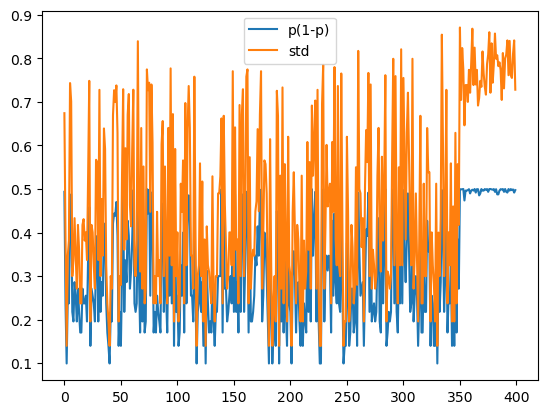

In [143]:
stdapr = np.sqrt(p*(1-p))
std = np.nanstd(C, axis=0)

plt.plot(range(400), stdapr, label='p(1-p)')
plt.plot(range(400), std, label='std')
plt.legend()

In [29]:
Ch, _U, s, Vh = svd2(C, 49)

In [31]:
U = _U[:,np.argsort(s)[::-1]]
U[:,0]

array([-6.86888364e-03,  9.63162112e-02, -6.99143107e-02,  1.30831231e-01,
       -2.02432569e-01,  8.98822537e-02, -1.60142656e-01,  1.08841431e-01,
        5.31635176e-02, -2.29663656e-01, -1.72521433e-01,  2.14502877e-01,
       -1.41232064e-01, -1.44826311e-01, -2.03292904e-01, -1.59006217e-02,
        1.94040345e-01, -1.01480462e-01,  2.19760172e-01,  9.88844459e-04,
        1.27934886e-02,  7.41597297e-02, -1.03029014e-01,  2.64666510e-02,
       -1.18564075e-01, -1.94812373e-01,  7.56262301e-02,  3.10430943e-02,
        9.64791499e-02,  1.79067443e-01, -1.88662619e-01, -2.00605125e-01,
       -2.33082765e-01,  1.28508483e-01,  1.64219020e-01, -3.19463965e-02,
        1.54077368e-01,  9.82503484e-02, -1.15710505e-01,  1.98482931e-01,
        2.48919105e-01,  1.99867150e-01, -1.92630440e-02, -1.43061570e-01,
       -1.83531806e-01,  1.21886827e-01,  1.07831635e-05,  1.23926054e-01,
       -8.36989449e-02,  2.21333706e-02])

In [21]:
## normalize U
norms = np.linalg.norm(_U, axis=0)
_U = _U/norms
U = _U[:,np.argsort(s)[::-1]]


In [22]:
s

array([2.61495062, 3.65282143])

In [23]:
U.shape

(50, 2)

In [25]:
np.linalg.norm(_U[:,0])

1.0

In [65]:
import scipy
U1, S1, V1 = scipy.linalg.svd(Z.T)
S1**2

array([9355.45519706, 1357.14246417, 1040.3260335 ,  507.43065642,
        401.39675911,  341.77678588,  315.10114169,  301.97476921,
        289.24151299,  273.61847261,  264.52945798,  255.07813344,
        251.15021961,  234.04745507,  229.86120491,  217.84015421,
        212.66034071,  210.03960174,  201.03325338,  193.21954289,
        180.22746316,  177.19468581,  172.71729324,  167.55271175,
        163.0361796 ,  158.94266789,  157.76585768,  149.44450513,
        143.83815215,  139.4034291 ,  132.63443693,  129.82372806,
        126.21010467,  118.65658883,  117.40487965,  112.884675  ,
        110.93889951,  108.39149454,  102.24172494,  100.42458895,
         93.36374404,   92.50667981,   84.00711541,   81.69933086,
         79.96370791,   76.96202171,   73.19252471,   69.78902526,
         64.11883692,   61.7397902 ])

In [73]:
U1, S1, V1 = scipy.linalg.svd(Z.T, full_matrices = False)
U1[:,0].shape

(400,)

array([[1.00250627, 0.57308398, 0.54096631, ..., 0.40520462, 0.4579143 ,
        0.40684024],
       [0.57308398, 1.00250627, 0.5373926 , ..., 0.42330509, 0.44028403,
        0.43772248],
       [0.54096631, 0.5373926 , 1.00250627, ..., 0.40621327, 0.4497697 ,
        0.41745739],
       ...,
       [0.40520462, 0.42330509, 0.40621327, ..., 1.00250627, 0.4454143 ,
        0.57851146],
       [0.4579143 , 0.44028403, 0.4497697 , ..., 0.4454143 , 1.00250627,
        0.49941133],
       [0.40684024, 0.43772248, 0.41745739, ..., 0.57851146, 0.49941133,
        1.00250627]])

In [72]:
np.linalg.norm(U1[:,1])

0.9999999999999998

In [29]:
x = np.linspace(-10, 10, 101)

In [110]:
tw = TracyWidom(beta=1)
pdf = tw.pdf(x)
cdf = tw.cdf(x)

In [111]:
1 - tw.cdf(1.638)

0.01877014839467761

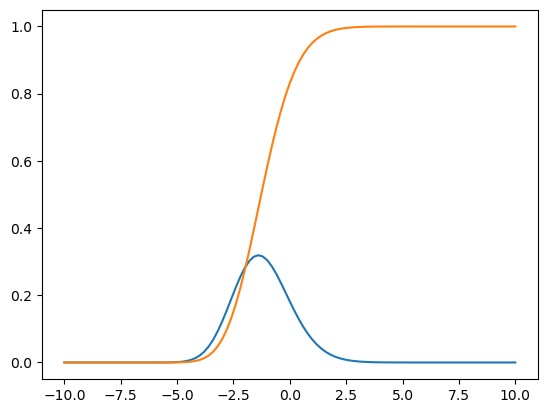

In [129]:
plt.plot(x, pdf)
plt.plot(x, cdf)

In [130]:
tw.cdfinv?

In [132]:
tw.cdf(-2.5)

0.15140699999999999